In [135]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

COVID = pd.read_excel('./owid-covid-data-ko.xlsx')
COVID = COVID.fillna(0)
COVID.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,KOR,Asia,South Korea,2020-01-22,1,0.0,0.0,0.0,0.0,0.0,...,6.2,40.9,0.0,12.27,83.03,0.916,0.0,0.00,0.00,0.000000
1,KOR,Asia,South Korea,2020-01-23,1,0.0,0.0,0.0,0.0,0.0,...,6.2,40.9,0.0,12.27,83.03,0.916,0.0,0.00,0.00,0.000000
2,KOR,Asia,South Korea,2020-01-24,2,1.0,0.0,0.0,0.0,0.0,...,6.2,40.9,0.0,12.27,83.03,0.916,0.0,0.00,0.00,0.000000
3,KOR,Asia,South Korea,2020-01-25,2,0.0,0.0,0.0,0.0,0.0,...,6.2,40.9,0.0,12.27,83.03,0.916,0.0,0.00,0.00,0.000000
4,KOR,Asia,South Korea,2020-01-26,3,1.0,0.0,0.0,0.0,0.0,...,6.2,40.9,0.0,12.27,83.03,0.916,43.4,0.17,2.47,0.845918


In [2]:
X = COVID[['new_cases_smoothed', 'new_deaths_smoothed', 'icu_patients',
'total_vaccinations', 'total_boosters', 'new_vaccinations_smoothed',
       'stringency_index']]
y = COVID['new_deaths']

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

In [4]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

In [5]:
from sklearn.metrics import mean_squared_error

pred_tr = reg.predict(X_train)
pred_test = reg.predict(X_test)

rmse_tr = np.sqrt(mean_squared_error(y_train, pred_tr))
rmse_test = np.sqrt(mean_squared_error(y_test, pred_test))

In [6]:
print('RMSE of Train Data: ', rmse_tr)
print('RMSE of Test Data: ', rmse_test)

RMSE of Train Data:  17.56872522732556
RMSE of Test Data:  17.601368966140907


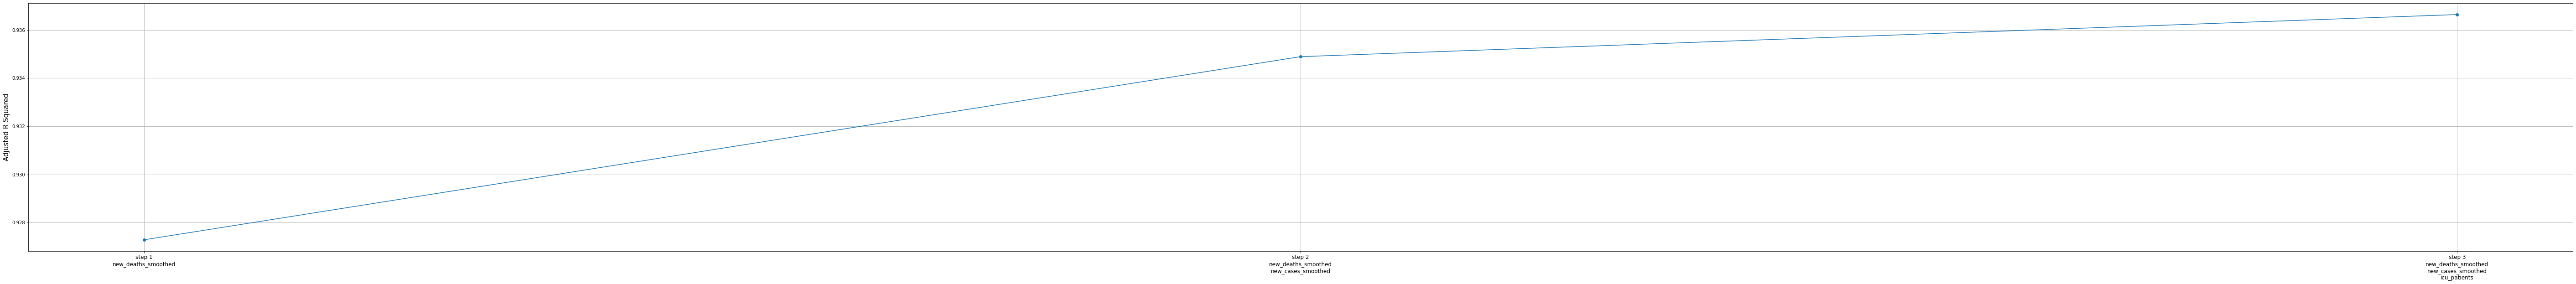

In [7]:
def stepwise_feature_selection(X_train, y_train, variables=X_train.columns.tolist() ): 
    import statsmodels.api as sm 
    import matplotlib.pyplot as plt 
    import warnings 
    warnings.filterwarnings("ignore") 
    y = y_train ## 반응 변수 
    selected_variables = [] ## 선택된 변수들 
    sl_enter = 0.05 
    sl_remove = 0.05 
    sv_per_step = [] ## 각 스텝별로 선택된 변수들 
    adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수 
    steps = [] ## 스텝 
    step = 0 
    while len(variables) > 0: 
        remainder = list(set(variables) - set(selected_variables)) 
        pval = pd.Series(index=remainder) ## 변수의 p-value ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서 ## 선형 모형을 적합한다. 
        for col in remainder: 
            X = X_train[selected_variables+[col]] 
            X = sm.add_constant(X) 
            model = sm.OLS(y,X).fit(disp=0) 
            pval[col] = model.pvalues[col] 
            min_pval = pval.min() 
        if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함 
            selected_variables.append(pval.idxmin()) ## 선택된 변수들에대해서 ## 어떤 변수를 제거할지 고른다. 
            while len(selected_variables) > 0: 
                selected_X = X_train[selected_variables] 
                selected_X = sm.add_constant(selected_X) 
                selected_pval = sm.OLS(y,selected_X).fit(disp=0).pvalues[1:] ## 절편항의 p-value는 뺀다 
                max_pval = selected_pval.max() 
                if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외 
                    remove_variable = selected_pval.idxmax() 
                    selected_variables.remove(remove_variable) 
                else: 
                    break 
            step += 1 
            steps.append(step) 
            adj_r_squared = sm.OLS(y,sm.add_constant(X_train[selected_variables])).fit(disp=0).rsquared_adj 
            adjusted_r_squared.append(adj_r_squared) 
            sv_per_step.append(selected_variables.copy()) 
        else: 
            break 
    fig = plt.figure(figsize=(100,10)) 
    fig.set_facecolor('white') 
    font_size = 15 
    plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=12) 
    
    plt.plot(steps,adjusted_r_squared, marker='o') 
    
    plt.ylabel('Adjusted R Squared',fontsize=font_size) 
    plt.grid(True) 
    plt.show() 

    return selected_variables 
selected_variables = stepwise_feature_selection(X_train, y_train)

In [8]:
model = sm.OLS(y_train, sm.add_constant(pd.DataFrame(X_train[selected_variables]))).fit(disp=0) 
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             new_deaths   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     3297.
Date:                Tue, 10 May 2022   Prob (F-statistic):               0.00
Time:                        22:26:39   Log-Likelihood:                -2872.6
No. Observations:                 670   AIC:                             5753.
Df Residuals:                     666   BIC:                             5771.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.9852    

In [9]:
['total_cases', 'new_cases', 'reproduction_rate', 'hosp_patients', 'icu_patients', 'positive_rate', 'weekly_icu_admissions', 'weekly_hosp_admissions', 'total_tests', 'new_tests', 'positive_rate', 'tests_per_case', 'total_vaccinations', 'stringency_index']

['total_cases',
 'new_cases',
 'reproduction_rate',
 'hosp_patients',
 'icu_patients',
 'positive_rate',
 'weekly_icu_admissions',
 'weekly_hosp_admissions',
 'total_tests',
 'new_tests',
 'positive_rate',
 'tests_per_case',
 'total_vaccinations',
 'stringency_index']

In [32]:
[['new_cases_smoothed', 'new_deaths_smoothed', 'total_boosters', 'new_vaccinations_smoothed',
       ]]

[['new_cases_smoothed',
  'new_deaths_smoothed',
  'icu_patients',
  'total_vaccinations',
  'total_boosters',
  'new_vaccinations_smoothed',
  'stringency_index']]

In [24]:
X = COVID[['total_cases', 'new_cases', 'reproduction_rate', 'icu_patients', 'positive_rate', 'weekly_icu_admissions', 'weekly_hosp_admissions', 'total_tests', 'new_tests', 'tests_per_case', 'total_vaccinations', 'stringency_index' ]]
y = COVID[['new_deaths']]

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

In [26]:
X_train

,total_cases,new_cases,reproduction_rate,icu_patients,positive_rate,weekly_icu_admissions,weekly_hosp_admissions,total_tests,new_tests,tests_per_case,total_vaccinations,stringency_index
206,15318,279.0,3.11,14.0,0.0131,0.0,0.0,1673944.0,10212.0,76.1,0.0,53.24
677,447230,3030.0,1.20,629.0,0.0000,0.0,4543.0,0.0,0.0,0.0,85371460.0,40.28
819,16674045,90825.0,0.59,808.0,0.4814,0.0,6242.0,43612398.0,203803.0,2.1,121685966.0,16.67
737,811122,17540.0,1.79,316.0,0.0000,0.0,5887.0,0.0,0.0,0.0,114126148.0,50.93
682,473034,5127.0,1.28,752.0,0.0000,530.0,4716.0,0.0,0.0,0.0,86739919.0,40.28
...,...,...,...,...,...,...,...,...,...,...,...,...
742,907214,22904.0,1.58,278.0,0.0000,0.0,7328.0,0.0,0.0,0.0,114562601.0,50.93
528,160084,742.0,1.23,144.0,0.0000,0.0,0.0,0.0,0.0,0.0,19789650.0,36.57
74,10237,81.0,0.73,81.0,0.0097,0.0,0.0,459881.0,6201.0,102.6,0.0,78.70
176,13672,60.0,1.02,16.0,0.0048,0.0,0.0,1439996.0,10032.0,208.3,0.0,53.24


In [27]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

In [28]:
from sklearn.metrics import mean_squared_error

pred_tr = reg.predict(X_train)
pred_test = reg.predict(X_test)

rmse_tr = np.sqrt(mean_squared_error(y_train, pred_tr))
rmse_test = np.sqrt(mean_squared_error(y_test, pred_test))

print('RMSE of Train Data: ', rmse_tr)
print('RMSE of Test Data: ', rmse_test)

In [29]:
print('RMSE of Train Data: ', rmse_tr)
print('RMSE of Test Data: ', rmse_test)

RMSE of Train Data:  19.42546232834527
RMSE of Test Data:  18.968377311464796


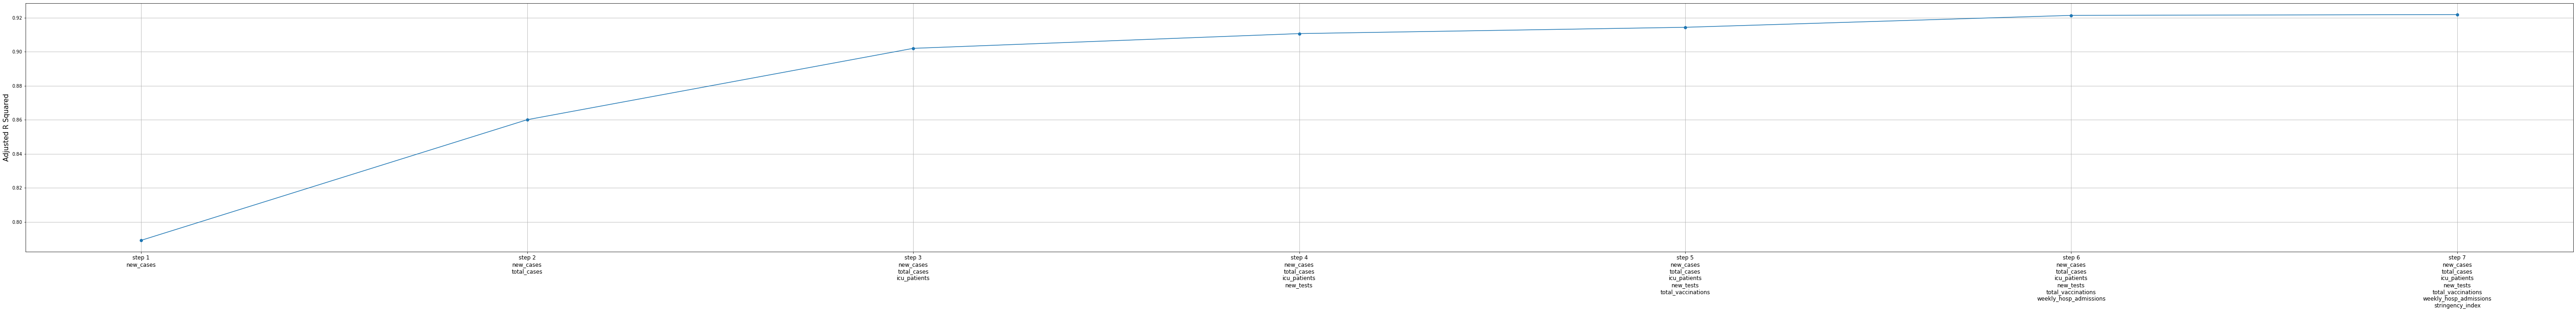

In [30]:
def stepwise_feature_selection(X_train, y_train, variables=X_train.columns.tolist() ): 
    import statsmodels.api as sm 
    import matplotlib.pyplot as plt 
    import warnings 
    warnings.filterwarnings("ignore") 
    y = y_train ## 반응 변수 
    selected_variables = [] ## 선택된 변수들 
    sl_enter = 0.05 
    sl_remove = 0.05 
    sv_per_step = [] ## 각 스텝별로 선택된 변수들 
    adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수 
    steps = [] ## 스텝 
    step = 0 
    while len(variables) > 0: 
        remainder = list(set(variables) - set(selected_variables)) 
        pval = pd.Series(index=remainder) ## 변수의 p-value ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서 ## 선형 모형을 적합한다. 
        for col in remainder: 
            X = X_train[selected_variables+[col]] 
            X = sm.add_constant(X) 
            model = sm.OLS(y,X).fit(disp=0) 
            pval[col] = model.pvalues[col] 
            min_pval = pval.min() 
        if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함 
            selected_variables.append(pval.idxmin()) ## 선택된 변수들에대해서 ## 어떤 변수를 제거할지 고른다. 
            while len(selected_variables) > 0: 
                selected_X = X_train[selected_variables] 
                selected_X = sm.add_constant(selected_X) 
                selected_pval = sm.OLS(y,selected_X).fit(disp=0).pvalues[1:] ## 절편항의 p-value는 뺀다 
                max_pval = selected_pval.max() 
                if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외 
                    remove_variable = selected_pval.idxmax() 
                    selected_variables.remove(remove_variable) 
                else: 
                    break 
            step += 1 
            steps.append(step) 
            adj_r_squared = sm.OLS(y,sm.add_constant(X_train[selected_variables])).fit(disp=0).rsquared_adj 
            adjusted_r_squared.append(adj_r_squared) 
            sv_per_step.append(selected_variables.copy()) 
        else: 
            break 
    fig = plt.figure(figsize=(100,10)) 
    fig.set_facecolor('white') 
    font_size = 15 
    plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=12) 
    
    plt.plot(steps,adjusted_r_squared, marker='o') 
    
    plt.ylabel('Adjusted R Squared',fontsize=font_size) 
    plt.grid(True) 
    plt.show() 

    return selected_variables 
selected_variables = stepwise_feature_selection(X_train, y_train)

In [31]:
model = sm.OLS(y_train, sm.add_constant(pd.DataFrame(X_train[selected_variables]))).fit(disp=0) 
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             new_deaths   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     1128.
Date:                Tue, 10 May 2022   Prob (F-statistic):               0.00
Time:                        22:30:35   Log-Likelihood:                -2941.0
No. Observations:                 670   AIC:                             5898.
Df Residuals:                     662   BIC:                             5934.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    -11

In [51]:
X = COVID[['new_cases', 'reproduction_rate', 'icu_patients', 'positive_rate', 'weekly_icu_admissions', 'weekly_hosp_admissions', 'total_tests', 'new_tests', 'tests_per_case', 'total_vaccinations', 'stringency_index', 'new_cases_smoothed', 'new_deaths_smoothed', 'total_boosters', 'new_vaccinations_smoothed' ]]
y = COVID[['new_deaths']]

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

In [56]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

In [57]:
from sklearn.metrics import mean_squared_error

pred_tr = reg.predict(X_train)
pred_test = reg.predict(X_test)

rmse_tr = np.sqrt(mean_squared_error(y_train, pred_tr))
rmse_test = np.sqrt(mean_squared_error(y_test, pred_test))

print('RMSE of Train Data: ', rmse_tr)
print('RMSE of Test Data: ', rmse_test)

RMSE of Train Data:  15.869653016863257
RMSE of Test Data:  19.691039653429147


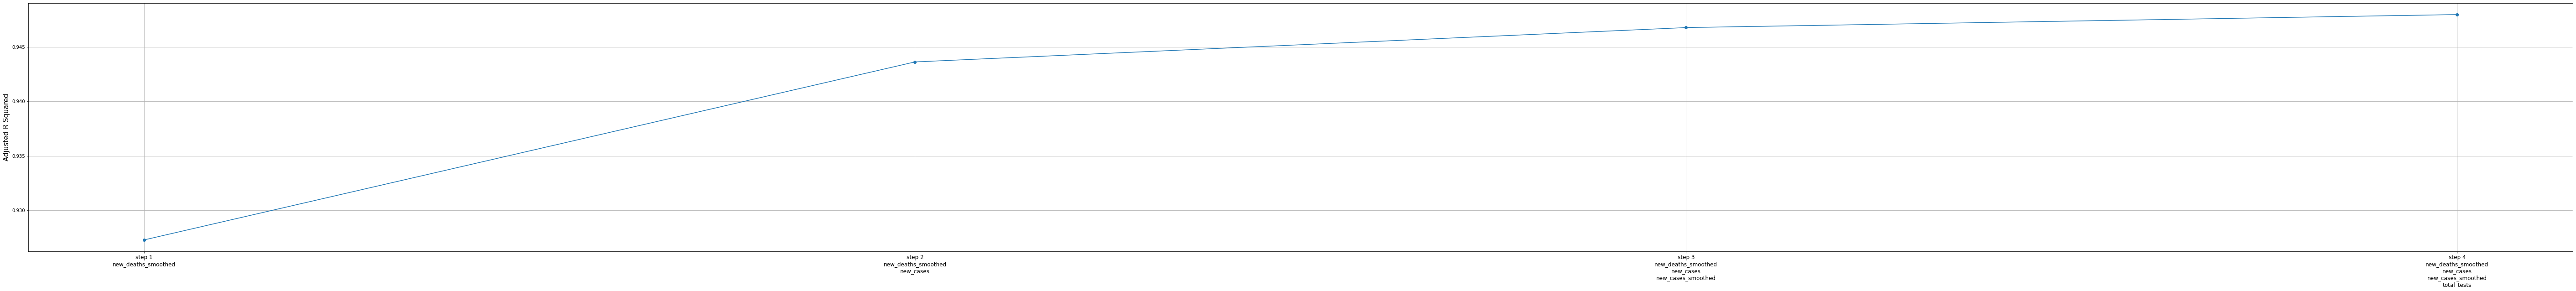

In [43]:
def stepwise_feature_selection(X_train, y_train, variables=X_train.columns.tolist() ): 
    import statsmodels.api as sm 
    import matplotlib.pyplot as plt 
    import warnings 
    warnings.filterwarnings("ignore") 
    y = y_train ## 반응 변수 
    selected_variables = [] ## 선택된 변수들 
    sl_enter = 0.05 
    sl_remove = 0.05 
    sv_per_step = [] ## 각 스텝별로 선택된 변수들 
    adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수 
    steps = [] ## 스텝 
    step = 0 
    while len(variables) > 0: 
        remainder = list(set(variables) - set(selected_variables)) 
        pval = pd.Series(index=remainder) ## 변수의 p-value ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서 ## 선형 모형을 적합한다. 
        for col in remainder: 
            X = X_train[selected_variables+[col]] 
            X = sm.add_constant(X) 
            model = sm.OLS(y,X).fit(disp=0) 
            pval[col] = model.pvalues[col] 
            min_pval = pval.min() 
        if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함 
            selected_variables.append(pval.idxmin()) ## 선택된 변수들에대해서 ## 어떤 변수를 제거할지 고른다. 
            while len(selected_variables) > 0: 
                selected_X = X_train[selected_variables] 
                selected_X = sm.add_constant(selected_X) 
                selected_pval = sm.OLS(y,selected_X).fit(disp=0).pvalues[1:] ## 절편항의 p-value는 뺀다 
                max_pval = selected_pval.max() 
                if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외 
                    remove_variable = selected_pval.idxmax() 
                    selected_variables.remove(remove_variable) 
                else: 
                    break 
            step += 1 
            steps.append(step) 
            adj_r_squared = sm.OLS(y,sm.add_constant(X_train[selected_variables])).fit(disp=0).rsquared_adj 
            adjusted_r_squared.append(adj_r_squared) 
            sv_per_step.append(selected_variables.copy()) 
        else: 
            break 
    fig = plt.figure(figsize=(100,10)) 
    fig.set_facecolor('white') 
    font_size = 15 
    plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=12) 
    
    plt.plot(steps,adjusted_r_squared, marker='o') 
    
    plt.ylabel('Adjusted R Squared',fontsize=font_size) 
    plt.grid(True) 
    plt.show() 

    return selected_variables 
selected_variables = stepwise_feature_selection(X_train, y_train)

In [44]:
model = sm.OLS(y_train, sm.add_constant(pd.DataFrame(X_train[selected_variables]))).fit(disp=0) 
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             new_deaths   R-squared:                       0.948
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     3048.
Date:                Tue, 10 May 2022   Prob (F-statistic):               0.00
Time:                        22:40:03   Log-Likelihood:                -2806.2
No. Observations:                 670   AIC:                             5622.
Df Residuals:                     665   BIC:                             5645.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.1825    

In [ ]:
['aged_70_older',
 'cardiovasc_death_rate',
 'female_smokers',
 'median_age',
 'population',
 'male_smokers',
 'aged_65_older',
 'life_expectancy',
 'population_density',
 'hospital_beds_per_thousand',
 'human_development_index',
 'diabetes_prevalence',
 'extreme_poverty',
 'excess_mortality']

In [203]:
X = COVID.drop(['new_deaths', 'total_deaths', 'new_deaths_per_million', 
'new_deaths_smoothed', 'new_deaths_smoothed_per_million', 'iso_code', 
'continent', 'location', 'date', 'tests_units', 'new_cases_smoothed_per_million',
 'total_cases_per_million', 'new_cases_smoothed', 'new_tests_smoothed', 
 'new_people_vaccinated_smoothed', 'new_tests_smoothed_per_thousand', 
 'people_fully_vaccinated_per_hundred', 'new_people_vaccinated_smoothed_per_hundred',
 'new_cases_per_million', 'excess_mortality_cumulative_per_million', 
 'total_vaccinations','total_deaths_per_million', 'total_vaccinations_per_hundred', 
 'new_tests', 'tests_per_case', 'weekly_hosp_admissions_per_million', 
 'people_vaccinated', 'total_boosters', 'new_vaccinations', 'new_vaccinations_smoothed', 
 'new_vaccinations_smoothed_per_million', 'hospital_beds_per_thousand', 'total_tests',
 'people_vaccinated_per_hundred', 'total_boosters_per_hundred', 'new_tests_per_thousand'], axis=1)
y = COVID['new_deaths']

In [231]:
e = ['new_deaths', 'total_deaths', 'new_deaths_per_million', 
'new_deaths_smoothed', 'new_deaths_smoothed_per_million', 'iso_code', 
'continent', 'location', 'date', 'tests_units', 'new_cases_smoothed_per_million',
 'total_cases_per_million', 'new_cases_smoothed', 'new_tests_smoothed', 
 'new_people_vaccinated_smoothed', 'new_tests_smoothed_per_thousand', 
 'people_fully_vaccinated_per_hundred', 'new_people_vaccinated_smoothed_per_hundred',
 'new_cases_per_million', 'excess_mortality_cumulative_per_million', 
 'total_vaccinations','total_deaths_per_million', 'total_vaccinations_per_hundred', 
 'new_tests', 'tests_per_case', 'weekly_hosp_admissions_per_million', 
 'people_vaccinated', 'total_boosters', 'new_vaccinations', 'new_vaccinations_smoothed', 
 'new_vaccinations_smoothed_per_million', 'hospital_beds_per_thousand', 'total_tests',
 'people_vaccinated_per_hundred', 'total_boosters_per_hundred', 'new_tests_per_thousand']

In [232]:
len(e)

36

In [204]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

In [ ]:
from sklearn.metrics import mean_squared_error

pred_tr = reg.predict(X_train)
pred_test = reg.predict(X_test)

rmse_tr = np.sqrt(mean_squared_error(y_train, pred_tr))
rmse_test = np.sqrt(mean_squared_error(y_test, pred_test))


In [177]:
print('RMSE of Train Data: ', rmse_tr)
print('RMSE of Test Data: ', rmse_test)

RMSE of Train Data:  21.47786376642436
RMSE of Test Data:  21.243950876263934


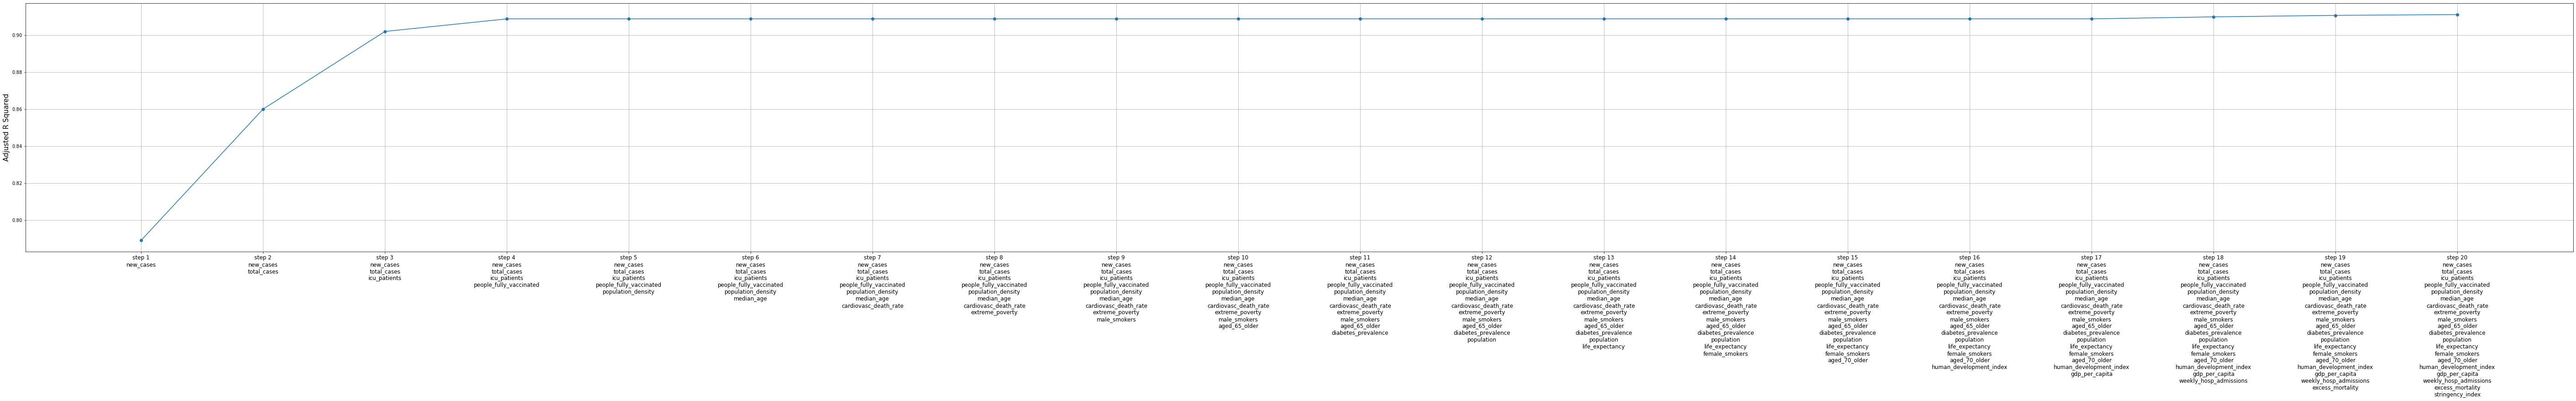

In [205]:
def stepwise_feature_selection(X_train, y_train, variables=X_train.columns.tolist() ): 
    import statsmodels.api as sm 
    import matplotlib.pyplot as plt 
    import warnings 
    warnings.filterwarnings("ignore") 
    y = y_train ## 반응 변수 
    selected_variables = [] ## 선택된 변수들 
    sl_enter = 0.05 
    sl_remove = 0.05 
    sv_per_step = [] ## 각 스텝별로 선택된 변수들 
    adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수 
    steps = [] ## 스텝 
    step = 0 
    while len(variables) > 0: 
        remainder = list(set(variables) - set(selected_variables)) 
        pval = pd.Series(index=remainder) ## 변수의 p-value ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서 ## 선형 모형을 적합한다. 
        for col in remainder: 
            X = X_train[selected_variables+[col]] 
            X = sm.add_constant(X) 
            model = sm.OLS(y,X).fit(disp=0) 
            pval[col] = model.pvalues[col] 
            min_pval = pval.min() 
        if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함 
            selected_variables.append(pval.idxmin()) ## 선택된 변수들에대해서 ## 어떤 변수를 제거할지 고른다. 
            while len(selected_variables) > 0: 
                selected_X = X_train[selected_variables] 
                selected_X = sm.add_constant(selected_X) 
                selected_pval = sm.OLS(y,selected_X).fit(disp=0).pvalues[1:] ## 절편항의 p-value는 뺀다 
                max_pval = selected_pval.max() 
                if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외 
                    remove_variable = selected_pval.idxmax() 
                    selected_variables.remove(remove_variable) 
                else: 
                    break 
            step += 1 
            steps.append(step) 
            adj_r_squared = sm.OLS(y,sm.add_constant(X_train[selected_variables])).fit(disp=0).rsquared_adj 
            adjusted_r_squared.append(adj_r_squared) 
            sv_per_step.append(selected_variables.copy()) 
        else: 
            break 
    fig = plt.figure(figsize=(100,10)) 
    fig.set_facecolor('white') 
    font_size = 15 
    plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=12) 
    
    plt.plot(steps,adjusted_r_squared, marker='o') 
    
    plt.ylabel('Adjusted R Squared',fontsize=font_size) 
    plt.grid(True) 
    plt.show() 

    return selected_variables 
selected_variables = stepwise_feature_selection(X_train, y_train)

In [206]:
model = sm.OLS(y_train, sm.add_constant(pd.DataFrame(X_train[selected_variables]))).fit(disp=0) 
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             new_deaths   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     980.3
Date:                Wed, 11 May 2022   Prob (F-statistic):               0.00
Time:                        16:12:59   Log-Likelihood:                -2984.1
No. Observations:                 670   AIC:                             5984.
Df Residuals:                     662   BIC:                             6020.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
new_cases                 

In [207]:
selected_variables

['new_cases',
 'total_cases',
 'icu_patients',
 'people_fully_vaccinated',
 'population_density',
 'median_age',
 'cardiovasc_death_rate',
 'extreme_poverty',
 'male_smokers',
 'aged_65_older',
 'diabetes_prevalence',
 'population',
 'life_expectancy',
 'female_smokers',
 'aged_70_older',
 'human_development_index',
 'gdp_per_capita',
 'weekly_hosp_admissions',
 'excess_mortality',
 'stringency_index']

In [ ]:
## 실제 예측값과 비교 및 시각화 

In [141]:
X = COVID[['new_cases_smoothed', 'icu_patients',
'total_vaccinations', 'total_boosters', 'reproduction_rate',
       'stringency_index']]
y = COVID['new_deaths']

In [142]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

In [143]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

In [144]:
from sklearn.metrics import mean_squared_error

pred_tr = reg.predict(X_train)
pred_test = reg.predict(X_test)

rmse_tr = np.sqrt(mean_squared_error(y_train, pred_tr))
rmse_test = np.sqrt(mean_squared_error(y_test, pred_test))

print('RMSE of Train Data: ', rmse_tr)
print('RMSE of Test Data: ', rmse_test)

RMSE of Train Data:  21.47786376642436
RMSE of Test Data:  21.243950876263934


In [145]:
def stepwise_feature_selection(X_train, y_train, variables=X_train.columns.tolist() ): 
    import statsmodels.api as sm 
    import matplotlib.pyplot as plt 
    import warnings 
    warnings.filterwarnings("ignore") 
    y = y_train ## 반응 변수 
    selected_variables = [] ## 선택된 변수들 
    sl_enter = 0.05 
    sl_remove = 0.05 
    sv_per_step = [] ## 각 스텝별로 선택된 변수들 
    adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수 
    steps = [] ## 스텝 
    step = 0 
    while len(variables) > 0: 
        remainder = list(set(variables) - set(selected_variables)) 
        pval = pd.Series(index=remainder) ## 변수의 p-value ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서 ## 선형 모형을 적합한다. 
        for col in remainder: 
            X = X_train[selected_variables+[col]] 
            X = sm.add_constant(X) 
            model = sm.OLS(y,X).fit(disp=0) 
            pval[col] = model.pvalues[col] 
            min_pval = pval.min() 
        if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함 
            selected_variables.append(pval.idxmin()) ## 선택된 변수들에대해서 ## 어떤 변수를 제거할지 고른다. 
            while len(selected_variables) > 0: 
                selected_X = X_train[selected_variables] 
                selected_X = sm.add_constant(selected_X) 
                selected_pval = sm.OLS(y,selected_X).fit(disp=0).pvalues[1:] ## 절편항의 p-value는 뺀다 
                max_pval = selected_pval.max() 
                if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외 
                    remove_variable = selected_pval.idxmax() 
                    selected_variables.remove(remove_variable) 
                else: 
                    break 
            step += 1 
            steps.append(step) 
            adj_r_squared = sm.OLS(y,sm.add_constant(X_train[selected_variables])).fit(disp=0).rsquared_adj 
            adjusted_r_squared.append(adj_r_squared) 
            sv_per_step.append(selected_variables.copy()) 
        else: 
            break 
    fig = plt.figure(figsize=(100,10)) 
    fig.set_facecolor('white') 
    font_size = 15 
    plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=12) 
    
    plt.plot(steps,adjusted_r_squared, marker='o') 
    
    plt.ylabel('Adjusted R Squared',fontsize=font_size) 
    plt.grid(True) 
    plt.show() 

    return selected_variables 
selected_variables = stepwise_feature_selection(X_train, y_train)

ValueError: attempt to get argmin of an empty sequence

In [116]:
model = sm.OLS(y_train, sm.add_constant(pd.DataFrame(X_train[selected_variables]))).fit(disp=0) 
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             new_deaths   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     1619.
Date:                Wed, 11 May 2022   Prob (F-statistic):               0.00
Time:                        15:33:44   Log-Likelihood:                -3003.2
No. Observations:                 670   AIC:                             6016.
Df Residuals:                     665   BIC:                             6039.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [146]:
model.predict()

array([-2.37546736e+00,  4.44056276e+01,  1.34029843e+02,  2.06539181e+01,
        5.50240274e+01, -3.06902573e+00,  1.82078446e+01,  4.66630986e+01,
       -1.13663469e-01,  1.50020814e+00,  2.68309272e+01, -2.18104867e+00,
        1.57910797e+00,  7.94337827e+00,  2.12947007e+01,  2.44152641e+01,
       -2.59115984e+00,  1.38494906e+01,  4.18424626e+00,  4.17424766e+00,
        2.19524206e+01,  5.60220672e+01,  5.14293055e+00,  1.90271820e+00,
        1.31690530e+01,  8.24206615e+00,  2.49422888e+02,  3.56776344e+00,
        1.64749283e+00,  4.26965516e+01,  3.69653764e-01,  6.35276671e+00,
        4.59609930e+01,  6.00337118e-01,  2.64639854e+00,  2.30503720e+00,
       -7.46488580e+00,  2.97158177e+00,  3.13246074e+01,  1.02248713e+01,
       -3.30937038e+00,  5.69407874e+01,  5.32026558e+01,  1.73301424e+01,
        1.71526854e+01,  7.64406186e+00, -2.58648354e+00,  2.88053202e+02,
        1.26573238e+00,  6.57572438e+00, -3.74926425e+00, -3.56608818e+00,
       -1.77224031e+00, -

In [148]:
selected_variables

['new_cases_smoothed',
 'icu_patients',
 'new_vaccinations_smoothed',
 'stringency_index']

In [208]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

COVID = pd.read_excel('./owid-covid-data.xlsx')
COVID = COVID.fillna(0)
COVID.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,37.746,0.5,64.83,0.511,0.0,0.0,0.0,0.0
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,37.746,0.5,64.83,0.511,0.0,0.0,0.0,0.0
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,37.746,0.5,64.83,0.511,0.0,0.0,0.0,0.0
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,37.746,0.5,64.83,0.511,0.0,0.0,0.0,0.0
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,37.746,0.5,64.83,0.511,0.0,0.0,0.0,0.0


In [209]:
COVID['location'].unique()

array(['Afghanistan', 'Africa', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Asia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Cook Islands',
       'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao',
       'Cyprus', 'Czechia', 'Democratic Republic of Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini', 'Ethi

In [213]:
COVIDIndia = COVID[COVID['location'] == 'India']

In [214]:
COVIDIndia

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
76597,IND,Asia,India,2020-01-30,1.0,1.0,0.000,0.0,0.0,0.000,...,1.9,20.6,59.55,0.53,69.66,0.645,0.0,0.0,0.0,0.0
76598,IND,Asia,India,2020-01-31,1.0,0.0,0.000,0.0,0.0,0.000,...,1.9,20.6,59.55,0.53,69.66,0.645,0.0,0.0,0.0,0.0
76599,IND,Asia,India,2020-02-01,1.0,0.0,0.000,0.0,0.0,0.000,...,1.9,20.6,59.55,0.53,69.66,0.645,0.0,0.0,0.0,0.0
76600,IND,Asia,India,2020-02-02,2.0,1.0,0.000,0.0,0.0,0.000,...,1.9,20.6,59.55,0.53,69.66,0.645,0.0,0.0,0.0,0.0
76601,IND,Asia,India,2020-02-03,3.0,1.0,0.000,0.0,0.0,0.000,...,1.9,20.6,59.55,0.53,69.66,0.645,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77422,IND,Asia,India,2022-05-04,43091393.0,3275.0,3227.714,523975.0,55.0,40.286,...,1.9,20.6,59.55,0.53,69.66,0.645,0.0,0.0,0.0,0.0
77423,IND,Asia,India,2022-05-05,43094938.0,3545.0,3251.714,524002.0,27.0,35.571,...,1.9,20.6,59.55,0.53,69.66,0.645,0.0,0.0,0.0,0.0
77424,IND,Asia,India,2022-05-06,43098743.0,3805.0,3268.429,524024.0,22.0,31.571,...,1.9,20.6,59.55,0.53,69.66,0.645,0.0,0.0,0.0,0.0
77425,IND,Asia,India,2022-05-07,43102194.0,3451.0,3286.571,524064.0,40.0,31.571,...,1.9,20.6,59.55,0.53,69.66,0.645,0.0,0.0,0.0,0.0


In [233]:
X = COVID.drop(['new_deaths', 'total_deaths', 'new_deaths_per_million', 
'new_deaths_smoothed', 'new_deaths_smoothed_per_million', 'iso_code', 
'continent', 'location', 'date', 'tests_units', 'new_cases_smoothed_per_million',
 'total_cases_per_million', 'new_cases_smoothed', 'new_tests_smoothed', 
 'new_people_vaccinated_smoothed', 'new_tests_smoothed_per_thousand', 
 'people_fully_vaccinated_per_hundred', 'new_people_vaccinated_smoothed_per_hundred',
 'new_cases_per_million', 'excess_mortality_cumulative_per_million', 
 'total_vaccinations','total_deaths_per_million', 'total_vaccinations_per_hundred', 
 'new_tests', 'tests_per_case', 'weekly_hosp_admissions_per_million', 
 'people_vaccinated', 'total_boosters', 'new_vaccinations', 'new_vaccinations_smoothed', 
 'new_vaccinations_smoothed_per_million', 'hospital_beds_per_thousand', 'total_tests',
 'people_vaccinated_per_hundred', 'total_boosters_per_hundred', 'new_tests_per_thousand'], axis=1)
y = COVID['new_deaths']

In [234]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

In [235]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

In [236]:
from sklearn.metrics import mean_squared_error

pred_tr = reg.predict(X_train)
pred_test = reg.predict(X_test)

rmse_tr = np.sqrt(mean_squared_error(y_train, pred_tr))
rmse_test = np.sqrt(mean_squared_error(y_test, pred_test))

print('RMSE of Train Data: ', rmse_tr)
print('RMSE of Test Data: ', rmse_test)

In [237]:
print('RMSE of Train Data: ', rmse_tr)
print('RMSE of Test Data: ', rmse_test)

RMSE of Train Data:  413.9089001420184
RMSE of Test Data:  405.7406145922124


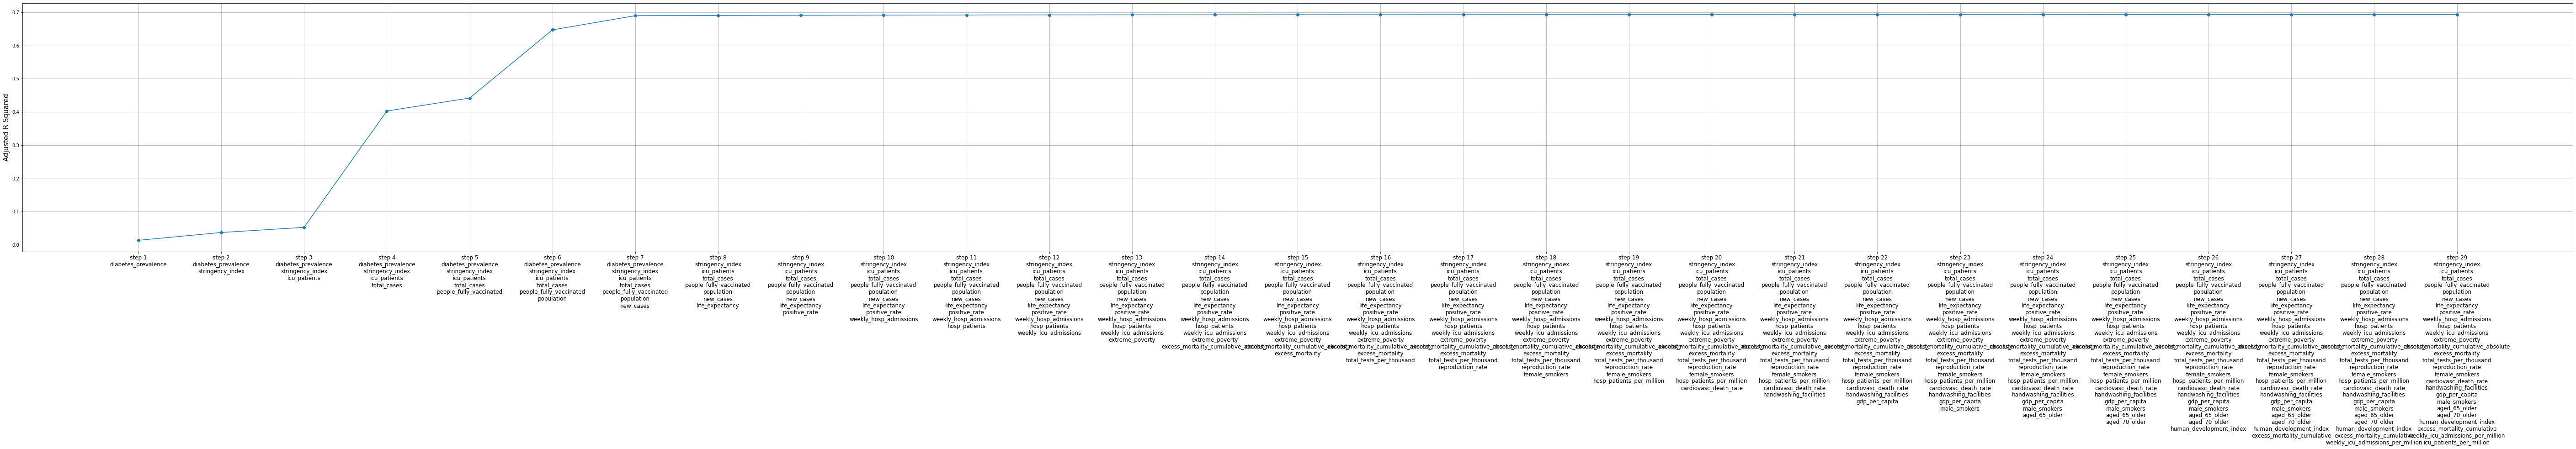

In [238]:
def stepwise_feature_selection(X_train, y_train, variables=X_train.columns.tolist() ): 
    import statsmodels.api as sm 
    import matplotlib.pyplot as plt 
    import warnings 
    warnings.filterwarnings("ignore") 
    y = y_train ## 반응 변수 
    selected_variables = [] ## 선택된 변수들 
    sl_enter = 0.05 
    sl_remove = 0.05 
    sv_per_step = [] ## 각 스텝별로 선택된 변수들 
    adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수 
    steps = [] ## 스텝 
    step = 0 
    while len(variables) > 0: 
        remainder = list(set(variables) - set(selected_variables)) 
        pval = pd.Series(index=remainder) ## 변수의 p-value ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서 ## 선형 모형을 적합한다. 
        for col in remainder: 
            X = X_train[selected_variables+[col]] 
            X = sm.add_constant(X) 
            model = sm.OLS(y,X).fit(disp=0) 
            pval[col] = model.pvalues[col] 
            min_pval = pval.min() 
        if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함 
            selected_variables.append(pval.idxmin()) ## 선택된 변수들에대해서 ## 어떤 변수를 제거할지 고른다. 
            while len(selected_variables) > 0: 
                selected_X = X_train[selected_variables] 
                selected_X = sm.add_constant(selected_X) 
                selected_pval = sm.OLS(y,selected_X).fit(disp=0).pvalues[1:] ## 절편항의 p-value는 뺀다 
                max_pval = selected_pval.max() 
                if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외 
                    remove_variable = selected_pval.idxmax() 
                    selected_variables.remove(remove_variable) 
                else: 
                    break 
            step += 1 
            steps.append(step) 
            adj_r_squared = sm.OLS(y,sm.add_constant(X_train[selected_variables])).fit(disp=0).rsquared_adj 
            adjusted_r_squared.append(adj_r_squared) 
            sv_per_step.append(selected_variables.copy()) 
        else: 
            break 
    fig = plt.figure(figsize=(100,10)) 
    fig.set_facecolor('white') 
    font_size = 15 
    plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=12) 
    
    plt.plot(steps,adjusted_r_squared, marker='o') 
    
    plt.ylabel('Adjusted R Squared',fontsize=font_size) 
    plt.grid(True) 
    plt.show() 

    return selected_variables 
selected_variables = stepwise_feature_selection(X_train, y_train)

In [239]:
model = sm.OLS(y_train, sm.add_constant(pd.DataFrame(X_train[selected_variables]))).fit(disp=0) 
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             new_deaths   R-squared:                       0.693
Model:                            OLS   Adj. R-squared:                  0.693
Method:                 Least Squares   F-statistic:                 1.238e+04
Date:                Wed, 11 May 2022   Prob (F-statistic):               0.00
Time:                        17:06:27   Log-Likelihood:            -1.1002e+06
No. Observations:              147790   AIC:                         2.201e+06
Df Residuals:                  147762   BIC:                         2.201e+06
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [240]:
selected_variables

['stringency_index',
 'icu_patients',
 'total_cases',
 'people_fully_vaccinated',
 'population',
 'new_cases',
 'life_expectancy',
 'positive_rate',
 'weekly_hosp_admissions',
 'hosp_patients',
 'weekly_icu_admissions',
 'extreme_poverty',
 'excess_mortality_cumulative_absolute',
 'excess_mortality',
 'total_tests_per_thousand',
 'reproduction_rate',
 'female_smokers',
 'cardiovasc_death_rate',
 'handwashing_facilities',
 'gdp_per_capita',
 'male_smokers',
 'aged_65_older',
 'aged_70_older',
 'human_development_index',
 'excess_mortality_cumulative',
 'weekly_icu_admissions_per_million',
 'icu_patients_per_million']

In [246]:
X_train, X_test, y_train, y_test = train_test_split(X[selected_variables], y, test_size=0.2, random_state=13)

In [247]:
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(X_train[selected_variables], y_train)

pred_tr = reg.predict(X_train)
pred_test = reg.predict(X_test)

rmse_tr = np.sqrt(mean_squared_error(y_train, pred_tr))
rmse_test = np.sqrt(mean_squared_error(y_test, pred_test))

print('RMSE of Train Data: ', rmse_tr)
print('RMSE of Test Data: ', rmse_test)

RMSE of Train Data:  413.91723091166176
RMSE of Test Data:  405.75976142669316


In [248]:
COVID_upper_10percent=COVID[COVID['gdp_per_capita']>44648.71]
COVID_upper_10percent

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
10510,AUT,Europe,Austria,2020-02-25,2.0,2.0,0.000,0.0,0.0,0.000,...,28.4,30.9,0.0,7.37,81.54,0.922,0.0,0.0,0.0,0.0
10511,AUT,Europe,Austria,2020-02-26,2.0,0.0,0.000,0.0,0.0,0.000,...,28.4,30.9,0.0,7.37,81.54,0.922,0.0,0.0,0.0,0.0
10512,AUT,Europe,Austria,2020-02-27,3.0,1.0,0.000,0.0,0.0,0.000,...,28.4,30.9,0.0,7.37,81.54,0.922,0.0,0.0,0.0,0.0
10513,AUT,Europe,Austria,2020-02-28,3.0,0.0,0.000,0.0,0.0,0.000,...,28.4,30.9,0.0,7.37,81.54,0.922,0.0,0.0,0.0,0.0
10514,AUT,Europe,Austria,2020-02-29,9.0,6.0,0.000,0.0,0.0,0.000,...,28.4,30.9,0.0,7.37,81.54,0.922,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174866,USA,North America,United States,2022-05-04,81620383.0,114308.0,61513.429,996704.0,1960.0,556.571,...,19.1,24.6,0.0,2.77,78.86,0.926,0.0,0.0,0.0,0.0
174867,USA,North America,United States,2022-05-05,81694580.0,74197.0,61635.000,996964.0,260.0,542.857,...,19.1,24.6,0.0,2.77,78.86,0.926,0.0,0.0,0.0,0.0
174868,USA,North America,United States,2022-05-06,81831854.0,137274.0,72666.857,997318.0,354.0,532.857,...,19.1,24.6,0.0,2.77,78.86,0.926,0.0,0.0,0.0,0.0
174869,USA,North America,United States,2022-05-07,81858744.0,26890.0,73172.714,997503.0,185.0,541.571,...,19.1,24.6,0.0,2.77,78.86,0.926,0.0,0.0,0.0,0.0


In [282]:
X = COVID_upper_10percent.drop(['new_deaths', 'total_deaths', 'new_deaths_per_million', 
'new_deaths_smoothed', 'new_deaths_smoothed_per_million', 'iso_code', 
'continent', 'location', 'date', 'tests_units', 'new_cases_smoothed_per_million',
 'total_cases_per_million', 'new_cases_smoothed', 'new_tests_smoothed', 
 'new_people_vaccinated_smoothed', 'new_tests_smoothed_per_thousand', 
 'people_fully_vaccinated_per_hundred', 'new_people_vaccinated_smoothed_per_hundred',
 'new_cases_per_million', 'excess_mortality_cumulative_per_million', 
 'total_vaccinations','total_deaths_per_million', 'total_vaccinations_per_hundred', 
 'new_tests', 'tests_per_case', 'weekly_hosp_admissions_per_million', 
 'people_vaccinated', 'total_boosters', 'new_vaccinations', 'new_vaccinations_smoothed', 
 'new_vaccinations_smoothed_per_million', 'hospital_beds_per_thousand', 'total_tests',
 'people_vaccinated_per_hundred', 'total_boosters_per_hundred', 'new_tests_per_thousand', 'aged_70_older',
 'cardiovasc_death_rate','female_smokers','median_age','population','male_smokers',
 'aged_65_older','life_expectancy','population_density','hospital_beds_per_thousand',
 'human_development_index','diabetes_prevalence','extreme_poverty','excess_mortality',
 'weekly_icu_admissions_per_million', 'total_tests_per_thousand', 'hosp_patients_per_million',
 'gdp_per_capita', 'hosp_patients', 'icu_patients_per_million'], axis=1)
y = COVID_upper_10percent['new_deaths']

In [291]:
aa = ['new_deaths', 'total_deaths', 'new_deaths_per_million', 
'new_deaths_smoothed', 'new_deaths_smoothed_per_million', 'iso_code', 
'continent', 'location', 'date', 'tests_units', 'new_cases_smoothed_per_million',
 'total_cases_per_million', 'new_cases_smoothed', 'new_tests_smoothed', 
 'new_people_vaccinated_smoothed', 'new_tests_smoothed_per_thousand', 
 'people_fully_vaccinated_per_hundred', 'new_people_vaccinated_smoothed_per_hundred',
 'new_cases_per_million', 'excess_mortality_cumulative_per_million', 
 'total_vaccinations','total_deaths_per_million', 'total_vaccinations_per_hundred', 
 'new_tests', 'tests_per_case', 'weekly_hosp_admissions_per_million', 
 'people_vaccinated', 'total_boosters', 'new_vaccinations', 'new_vaccinations_smoothed', 
 'new_vaccinations_smoothed_per_million', 'hospital_beds_per_thousand', 'total_tests',
 'people_vaccinated_per_hundred', 'total_boosters_per_hundred', 'new_tests_per_thousand', 'aged_70_older',
 'cardiovasc_death_rate','female_smokers','median_age','population','male_smokers',
 'aged_65_older','life_expectancy','population_density','hospital_beds_per_thousand',
 'human_development_index','diabetes_prevalence','extreme_poverty','excess_mortality',
 'weekly_icu_admissions_per_million', 'total_tests_per_thousand', 'hosp_patients_per_million',
 'gdp_per_capita', 'hosp_patients', 'icu_patients_per_million']

In [292]:
len(aa)

56

In [283]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

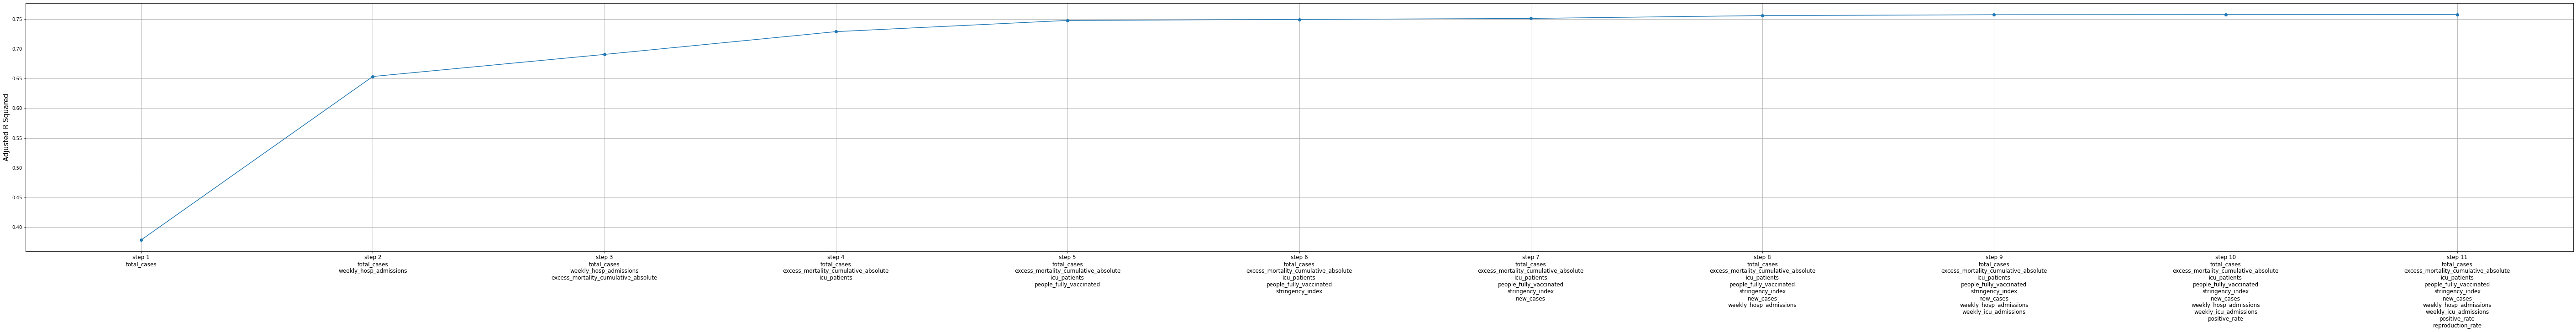

In [284]:
def stepwise_feature_selection(X_train, y_train, variables=X_train.columns.tolist() ): 
    import statsmodels.api as sm 
    import matplotlib.pyplot as plt 
    import warnings 
    warnings.filterwarnings("ignore") 
    y = y_train ## 반응 변수 
    selected_variables = [] ## 선택된 변수들 
    sl_enter = 0.05 
    sl_remove = 0.05 
    sv_per_step = [] ## 각 스텝별로 선택된 변수들 
    adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수 
    steps = [] ## 스텝 
    step = 0 
    while len(variables) > 0: 
        remainder = list(set(variables) - set(selected_variables)) 
        pval = pd.Series(index=remainder) ## 변수의 p-value ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서 ## 선형 모형을 적합한다. 
        for col in remainder: 
            X = X_train[selected_variables+[col]] 
            X = sm.add_constant(X) 
            model = sm.OLS(y,X).fit(disp=0) 
            pval[col] = model.pvalues[col] 
            min_pval = pval.min() 
        if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함 
            selected_variables.append(pval.idxmin()) ## 선택된 변수들에대해서 ## 어떤 변수를 제거할지 고른다. 
            while len(selected_variables) > 0: 
                selected_X = X_train[selected_variables] 
                selected_X = sm.add_constant(selected_X) 
                selected_pval = sm.OLS(y,selected_X).fit(disp=0).pvalues[1:] ## 절편항의 p-value는 뺀다 
                max_pval = selected_pval.max() 
                if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외 
                    remove_variable = selected_pval.idxmax() 
                    selected_variables.remove(remove_variable) 
                else: 
                    break 
            step += 1 
            steps.append(step) 
            adj_r_squared = sm.OLS(y,sm.add_constant(X_train[selected_variables])).fit(disp=0).rsquared_adj 
            adjusted_r_squared.append(adj_r_squared) 
            sv_per_step.append(selected_variables.copy()) 
        else: 
            break 
    fig = plt.figure(figsize=(100,10)) 
    fig.set_facecolor('white') 
    font_size = 15 
    plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=12) 
    
    plt.plot(steps,adjusted_r_squared, marker='o') 
    
    plt.ylabel('Adjusted R Squared',fontsize=font_size) 
    plt.grid(True) 
    plt.show() 

    return selected_variables 
selected_variables = stepwise_feature_selection(X_train, y_train)

In [285]:
model = sm.OLS(y_train, sm.add_constant(pd.DataFrame(X_train[selected_variables]))).fit(disp=0) 
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             new_deaths   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.758
Method:                 Least Squares   F-statistic:                     4470.
Date:                Wed, 11 May 2022   Prob (F-statistic):               0.00
Time:                        18:50:43   Log-Likelihood:                -93074.
No. Observations:               14280   AIC:                         1.862e+05
Df Residuals:                   14269   BIC:                         1.863e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [286]:
selected_variables

['total_cases',
 'excess_mortality_cumulative_absolute',
 'icu_patients',
 'people_fully_vaccinated',
 'stringency_index',
 'new_cases',
 'weekly_hosp_admissions',
 'weekly_icu_admissions',
 'positive_rate',
 'reproduction_rate']

In [293]:
COVID

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,0.000,0.0,0.0,0.000,...,0.0,0.0,37.746,0.5,64.83,0.511,0.0,0.0,0.0,0.0
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,0.000,0.0,0.0,0.000,...,0.0,0.0,37.746,0.5,64.83,0.511,0.0,0.0,0.0,0.0
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,0.000,0.0,0.0,0.000,...,0.0,0.0,37.746,0.5,64.83,0.511,0.0,0.0,0.0,0.0
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,0.000,0.0,0.0,0.000,...,0.0,0.0,37.746,0.5,64.83,0.511,0.0,0.0,0.0,0.0
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,0.000,0.0,0.0,0.000,...,0.0,0.0,37.746,0.5,64.83,0.511,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184733,ZWE,Africa,Zimbabwe,2022-05-04,248050.0,60.0,45.857,5471.0,1.0,0.286,...,1.6,30.7,36.791,1.7,61.49,0.571,0.0,0.0,0.0,0.0
184734,ZWE,Africa,Zimbabwe,2022-05-05,248050.0,0.0,38.000,5471.0,0.0,0.286,...,1.6,30.7,36.791,1.7,61.49,0.571,0.0,0.0,0.0,0.0
184735,ZWE,Africa,Zimbabwe,2022-05-06,248214.0,164.0,53.143,5473.0,2.0,0.571,...,1.6,30.7,36.791,1.7,61.49,0.571,0.0,0.0,0.0,0.0
184736,ZWE,Africa,Zimbabwe,2022-05-07,248214.0,0.0,48.429,5473.0,0.0,0.571,...,1.6,30.7,36.791,1.7,61.49,0.571,0.0,0.0,0.0,0.0


In [288]:
X_train, X_test, y_train, y_test = train_test_split(X[selected_variables], y, test_size=0.2, random_state=13)

In [290]:
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(X_train[selected_variables], y_train)

pred_tr = reg.predict(X_train)
pred_test = reg.predict(X_test)

rmse_tr = np.sqrt(mean_squared_error(y_train, pred_tr))
rmse_test = np.sqrt(mean_squared_error(y_test, pred_test))

print('RMSE of Train Data: ', rmse_tr)
print('RMSE of Test Data: ', rmse_test)

RMSE of Train Data:  163.82909061895606
RMSE of Test Data:  164.23298405374481
